<a href="https://colab.research.google.com/github/anu04596/DeepLearningTuotorial/blob/main/Day8(ResNet18).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import Subset

Data Preparation

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

])

In [12]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = trainset.classes  # ['airplane', 'automobile', ..., 'truck']



trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True )
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Load Pretrained ResNet18

In [4]:
model=models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


Freeze all pretrained layers

In [5]:
for param in model.parameters():
  param.requires_grad=False

Replace Final Fully Connected Layer

In [6]:
device = torch.device("cpu")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)


Loss Function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Train and evaluate function

In [13]:
def train(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print every 100 batches
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}], Batch [{i+1}/{len(loader)}], Loss: {running_loss / 100:.4f}")
            running_loss = 0.0


In [9]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Training and evaluating

In [14]:
for epoch in range(2):
    train(model, trainloader, optimizer, criterion, device, epoch)
    evaluate(model, testloader)

Epoch [1], Batch [100/782], Loss: 1.9247
Epoch [1], Batch [200/782], Loss: 1.6811
Epoch [1], Batch [300/782], Loss: 1.5053
Epoch [1], Batch [400/782], Loss: 1.3756
Epoch [1], Batch [500/782], Loss: 1.2625
Epoch [1], Batch [600/782], Loss: 1.1975
Epoch [1], Batch [700/782], Loss: 1.1168
Test Accuracy: 72.19%
Epoch [2], Batch [100/782], Loss: 1.0155
Epoch [2], Batch [200/782], Loss: 0.9900
Epoch [2], Batch [300/782], Loss: 0.9489
Epoch [2], Batch [400/782], Loss: 0.9226
Epoch [2], Batch [500/782], Loss: 0.8945
Epoch [2], Batch [600/782], Loss: 0.8794
Epoch [2], Batch [700/782], Loss: 0.8604
Test Accuracy: 75.83%


Visualize Predictions

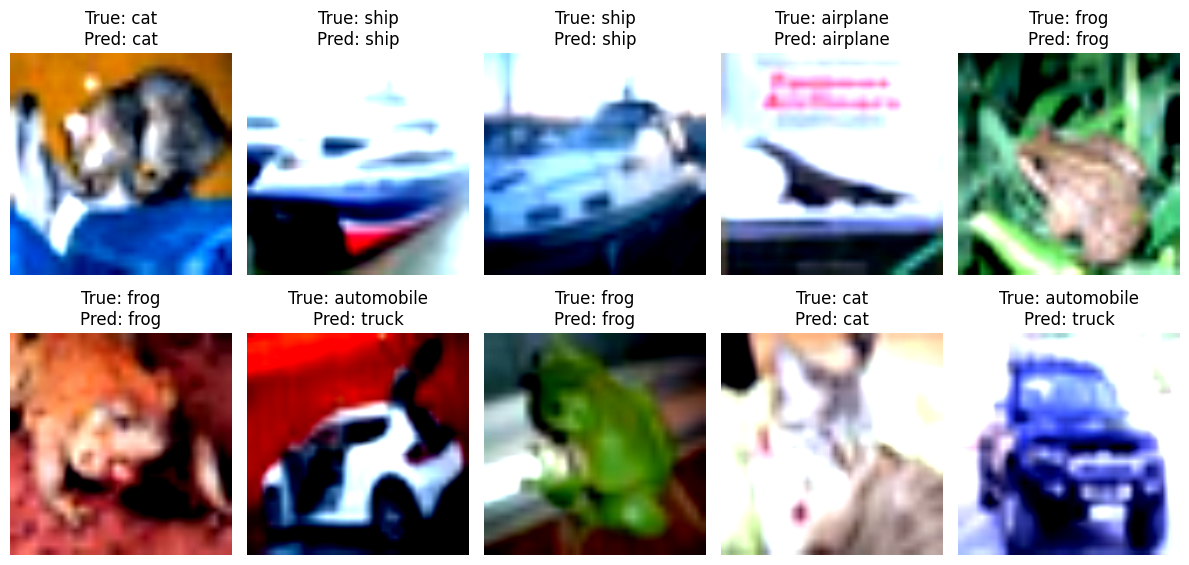

In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Un-normalize
    plt.imshow(img)
    plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()